<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/Pendulum_integrators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

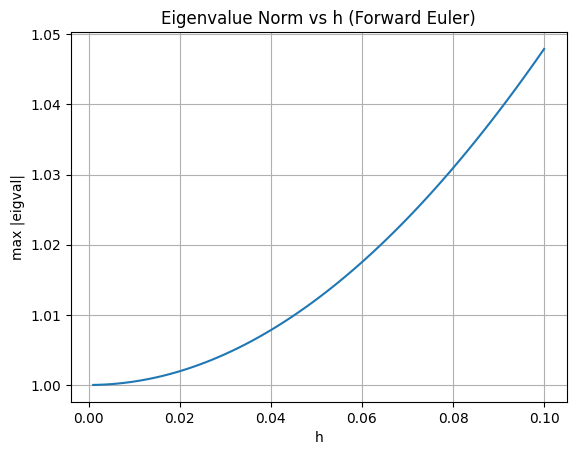

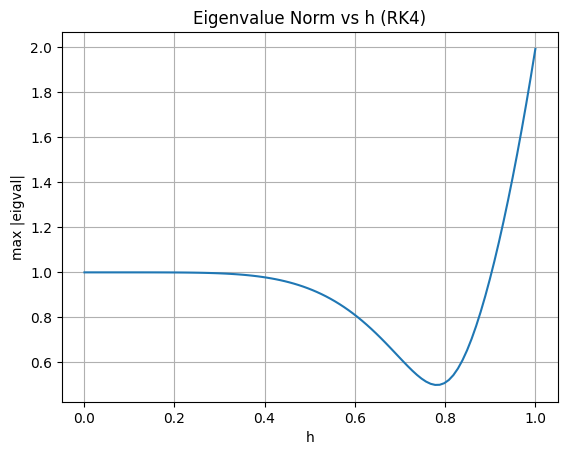

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from numpy.linalg import norm, eigvals
from autograd import jacobian
import autograd.numpy as anp # Import autograd.numpy

# ------------------------
# Dynamics Function
# ------------------------
def pendulum_dynamics(x):
    l = 1.0
    g = 9.81
    θ, θ_dot = x
    # Use anp.sin for autograd compatibility
    θ_ddot = -(g / l) * anp.sin(θ)
    return anp.array([θ_dot, θ_ddot]) # Return an autograd.numpy array


# ------------------------
# Forward Euler
# ------------------------
def pendulum_forward_euler(fun, x0, Tf, h):
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0

    for k in range(len(t) - 1):
        x_hist[:, k+1] = x_hist[:, k] + h * fun(x_hist[:, k])

    return x_hist, t


# ------------------------
# Discretized A matrix for Forward Euler
# ------------------------
def pendulum_euler_Ad(x0, h):
    g = 9.81
    return np.array([
        [1, h],
        [-g * h * np.cos(x0[0]), 1]
    ])


# ------------------------
# Plot eigenvalue norm vs. h (Forward Euler)
# ------------------------
eignorm = np.zeros(100)
h_vals = np.linspace(0.001, 0.1, 100)
for i, h in enumerate(h_vals):
    Ad = pendulum_euler_Ad(np.array([0, 0]), h)
    eignorm[i] = np.max(np.abs(eigvals(Ad)))

plt.figure()
plt.plot(h_vals, eignorm)
plt.title("Eigenvalue Norm vs h (Forward Euler)")
plt.xlabel("h")
plt.ylabel("max |eigval|")
plt.grid()


# ------------------------
# RK4 Integration
# ------------------------
def fd_pendulum_rk4(xk, h):
    f1 = pendulum_dynamics(xk)
    f2 = pendulum_dynamics(xk + 0.5 * h * f1)
    f3 = pendulum_dynamics(xk + 0.5 * h * f2)
    f4 = pendulum_dynamics(xk + h * f3)
    return xk + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)


def pendulum_rk4(fun, x0, Tf, h):
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0

    for k in range(len(t) - 1):
        x_hist[:, k+1] = fd_pendulum_rk4(x_hist[:, k], h)

    return x_hist, t


# ------------------------
# RK4 Jacobian Eigenvalue Norm vs h
# ------------------------
# from autograd import jacobian # Already imported above
# import autograd.numpy as anp # Already imported above

def rk4_autograd(x, h):
    # pendulum_dynamics now uses anp internally
    f1 = pendulum_dynamics(x)
    f2 = pendulum_dynamics(x + 0.5 * h * f1)
    f3 = pendulum_dynamics(x + 0.5 * h * f2)
    f4 = pendulum_dynamics(x + h * f3)
    return x + (h / 6.0) * (f1 + 2 * f2 + 2 * f3 + f4)

eignorm_rk4 = np.zeros(100)
h_vals_rk4 = np.linspace(0.001, 1.0, 100)
for i, h in enumerate(h_vals_rk4):
    # Pass anp.array to the function being differentiated
    J = jacobian(lambda x: rk4_autograd(x, h))(anp.array([0.0, 0.0]))
    eignorm_rk4[i] = np.max(np.abs(np.linalg.eigvals(J))) # Use np.linalg.eigvals


plt.figure()
plt.plot(h_vals_rk4, eignorm_rk4)
plt.title("Eigenvalue Norm vs h (RK4)")
plt.xlabel("h")
plt.ylabel("max |eigval|")
plt.grid()


# ------------------------
# Backward Euler Integration
# ------------------------
def pendulum_backward_euler(fun, x0, Tf, dt):
    t = np.arange(0, Tf + dt, dt)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0

    for k in range(len(t) - 1):
        def F(x_next):
            return x_next - x_hist[:, k] - dt * fun(x_next)

        sol = root(F, x_hist[:, k])
        x_hist[:, k+1] = sol.x

    return x_hist, t

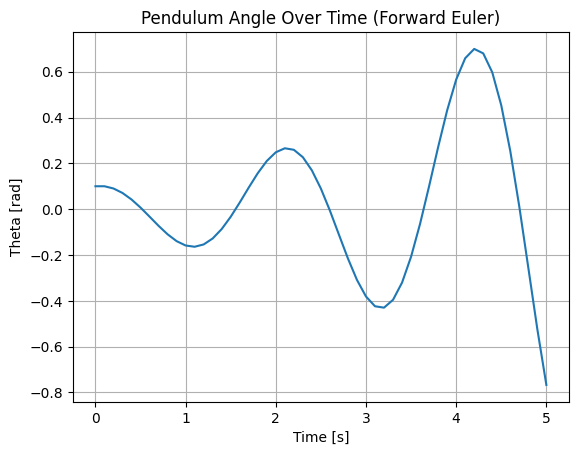

In [ ]:
# ------------------------
# Run Simulations & Plot
# ------------------------
x0 = np.array([0.1, 0])

# Forward Euler
x_hist1, t_hist1 = pendulum_forward_euler(pendulum_dynamics, x0, 5, 0.1)
plt.figure()
plt.plot(t_hist1, x_hist1[0, :])
plt.title("Pendulum Angle Over Time (Forward Euler)")
plt.xlabel("Time [s]")
plt.ylabel("Theta [rad]")
plt.grid()

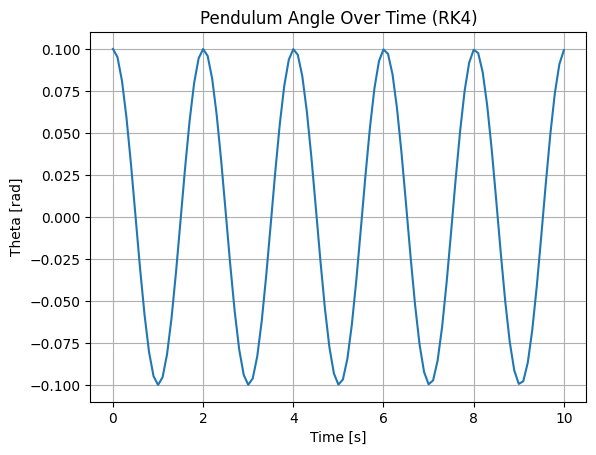

In [ ]:
# RK4
x_hist2, t_hist2 = pendulum_rk4(pendulum_dynamics, x0, 10, 0.1)
plt.figure()
plt.plot(t_hist2, x_hist2[0, :])
plt.title("Pendulum Angle Over Time (RK4)")
plt.xlabel("Time [s]")
plt.ylabel("Theta [rad]")
plt.grid()

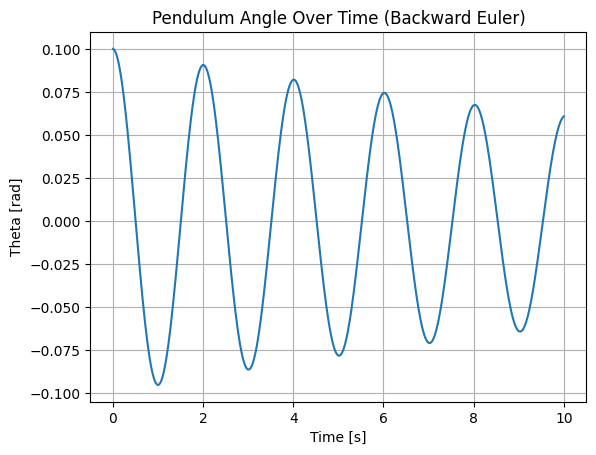

In [ ]:
# Backward Euler
x_hist3, t_hist3 = pendulum_backward_euler(pendulum_dynamics, x0, 10, 0.01)
plt.figure()
plt.plot(t_hist3, x_hist3[0, :])
plt.title("Pendulum Angle Over Time (Backward Euler)")
plt.xlabel("Time [s]")
plt.ylabel("Theta [rad]")
plt.grid()

plt.show()